In [4]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
_set_env('LANGCHAIN_TRACING_V2')
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

# dataset

In [9]:
from datasets import load_dataset

train_set = load_dataset("hotpot_qa", 'distractor', split='train', trust_remote_code=True)
dev_set = load_dataset("hotpot_qa", 'distractor', split='validation', trust_remote_code=True)

In [49]:
import os
import argparse

parser = argparse.ArgumentParser()

glove_word_file = "glove.840B.300d.txt"

word_emb_file = "word_emb.json"
char_emb_file = "char_emb.json"
train_eval = "train_eval.json"
dev_eval = "dev_eval.json"
test_eval = "test_eval.json"
word2idx_file = "word2idx.json"
char2idx_file = "char2idx.json"
idx2word_file = 'idx2word.json'
idx2char_file = 'idx2char.json'
train_record_file = 'train_record.pkl'
dev_record_file = 'dev_record.pkl'
test_record_file = 'test_record.pkl'


parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--data_file', type=str)
parser.add_argument('--glove_word_file', type=str, default=glove_word_file)
parser.add_argument('--save', type=str, default='HOTPOT')

parser.add_argument('--word_emb_file', type=str, default=word_emb_file)
parser.add_argument('--char_emb_file', type=str, default=char_emb_file)
parser.add_argument('--train_eval_file', type=str, default=train_eval)
parser.add_argument('--dev_eval_file', type=str, default=dev_eval)
parser.add_argument('--test_eval_file', type=str, default=test_eval)
parser.add_argument('--word2idx_file', type=str, default=word2idx_file)
parser.add_argument('--char2idx_file', type=str, default=char2idx_file)
parser.add_argument('--idx2word_file', type=str, default=idx2word_file)
parser.add_argument('--idx2char_file', type=str, default=idx2char_file)

parser.add_argument('--train_record_file', type=str, default=train_record_file)
parser.add_argument('--dev_record_file', type=str, default=dev_record_file)
parser.add_argument('--test_record_file', type=str, default=test_record_file)

parser.add_argument('--glove_char_size', type=int, default=94)
parser.add_argument('--glove_word_size', type=int, default=int(2.2e6))
parser.add_argument('--glove_dim', type=int, default=300)
parser.add_argument('--char_dim', type=int, default=8)

parser.add_argument('--para_limit', type=int, default=1000)
parser.add_argument('--ques_limit', type=int, default=80)
parser.add_argument('--sent_limit', type=int, default=100)
parser.add_argument('--char_limit', type=int, default=16)

parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--checkpoint', type=int, default=1000)
parser.add_argument('--period', type=int, default=100)
parser.add_argument('--init_lr', type=float, default=0.5)
parser.add_argument('--keep_prob', type=float, default=0.8)
parser.add_argument('--hidden', type=int, default=80)
parser.add_argument('--char_hidden', type=int, default=100)
parser.add_argument('--patience', type=int, default=1)
parser.add_argument('--seed', type=int, default=13)

parser.add_argument('--sp_lambda', type=float, default=0.0)

parser.add_argument('--data_split', type=str, default='train')
parser.add_argument('--fullwiki', action='store_true')
parser.add_argument('--prediction_file', type=str)
parser.add_argument('--sp_threshold', type=float, default=0.3)

config = parser.parse_args(args=[])


# Validation

In [1]:
def predict(data_source, model, eval_file, config, prediction_file):
    answer_dict = {}
    sp_dict = {}
    sp_th = config.sp_threshold
    for step, data in enumerate(tqdm(data_source)):
        '''
        Dataset load
        '''

        '''
        Model prediction
        answer_dict_ = 
        answer_dict.update(answer_dict_)
        '''

        predict_support_np = torch.sigmoid(predict_support[:, :, 1]).data.cpu().numpy()
        for i in range(predict_support_np.shape[0]):
            cur_sp_pred = []
            cur_id = data['ids'][i]
            for j in range(predict_support_np.shape[1]):
                if j >= len(eval_file[cur_id]['sent2title_ids']): break
                if predict_support_np[i, j] > sp_th:
                    cur_sp_pred.append(eval_file[cur_id]['sent2title_ids'][j])
            sp_dict.update({cur_id: cur_sp_pred})

    prediction = {'answer': answer_dict, 'sp': sp_dict}
    with open(prediction_file, 'w') as f:
        json.dump(prediction, f)

In [51]:
import sys
import ujson as json
import re
import string
from collections import Counter
import pickle

def normalize_answer(s):

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    ZERO_METRIC = (0, 0, 0)

    if normalized_prediction in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC
    if normalized_ground_truth in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return ZERO_METRIC
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, precision, recall


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def update_answer(metrics, prediction, gold):
    em = exact_match_score(prediction, gold)
    f1, prec, recall = f1_score(prediction, gold)
    metrics['em'] += float(em)
    metrics['f1'] += f1
    metrics['prec'] += prec
    metrics['recall'] += recall
    return em, prec, recall

def update_sp(metrics, prediction, gold):
    cur_sp_pred = set(map(tuple, prediction))
    gold_sp_pred = set(map(tuple, gold))
    tp, fp, fn = 0, 0, 0
    for e in cur_sp_pred:
        if e in gold_sp_pred:
            tp += 1
        else:
            fp += 1
    for e in gold_sp_pred:
        if e not in cur_sp_pred:
            fn += 1
    prec = 1.0 * tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = 1.0 * tp / (tp + fn) if tp + fn > 0 else 0.0
    f1 = 2 * prec * recall / (prec + recall) if prec + recall > 0 else 0.0
    em = 1.0 if fp + fn == 0 else 0.0
    metrics['sp_em'] += em
    metrics['sp_f1'] += f1
    metrics['sp_prec'] += prec
    metrics['sp_recall'] += recall
    return em, prec, recall

def eval(prediction_file, gold_file):
    with open(prediction_file) as f:
        prediction = json.load(f)
    with open(gold_file) as f:
        gold = json.load(f)

    metrics = {'em': 0, 'f1': 0, 'prec': 0, 'recall': 0,
        'sp_em': 0, 'sp_f1': 0, 'sp_prec': 0, 'sp_recall': 0,
        'joint_em': 0, 'joint_f1': 0, 'joint_prec': 0, 'joint_recall': 0}
    for dp in gold:
        cur_id = dp['_id']
        can_eval_joint = True
        if cur_id not in prediction['answer']:
            print('missing answer {}'.format(cur_id))
            can_eval_joint = False
        else:
            em, prec, recall = update_answer(
                metrics, prediction['answer'][cur_id], dp['answer'])
        if cur_id not in prediction['sp']:
            print('missing sp fact {}'.format(cur_id))
            can_eval_joint = False
        else:
            sp_em, sp_prec, sp_recall = update_sp(
                metrics, prediction['sp'][cur_id], dp['supporting_facts'])

        if can_eval_joint:
            joint_prec = prec * sp_prec
            joint_recall = recall * sp_recall
            if joint_prec + joint_recall > 0:
                joint_f1 = 2 * joint_prec * joint_recall / (joint_prec + joint_recall)
            else:
                joint_f1 = 0.
            joint_em = em * sp_em

            metrics['joint_em'] += joint_em
            metrics['joint_f1'] += joint_f1
            metrics['joint_prec'] += joint_prec
            metrics['joint_recall'] += joint_recall

    N = len(gold)
    for k in metrics.keys():
        metrics[k] /= N

    print(metrics)

if __name__ == '__main__':
    eval(sys.argv[1], sys.argv[2])



IndexError: list index out of range

# util

In [36]:
# util.py
def load_llm(model: str):
    if model == 'openai':
        from langchain_openai import ChatOpenAI
        llm = ChatOpenAI(
            model = "gpt-3.5-turbo", # "gpt-4o", "gpt-4", "gpt-3.5-turbo", "gpt-3.5", "gpt-3", "gpt-2", "gpt-1"
            temperature = 0
        )
    elif model == 'ollama':
        from langchain_ollama import OllamaLLM
        llm = OllamaLLM(
            model = 'llama3.2:3b-instruct-fp16',
            base_url = "http://localhost:11434",
            temperature = 0,
            verbose = True,
        )
    return llm

def return_possible_models():
    import ollama

    # Get the list of available models
    models = [i['model'] for i in ollama.list()['models']]
    print(models)

def connect_to_sql_memory():
    import sqlite3
    from langgraph.checkpoint.sqlite import SqliteSaver

    db_path = "state_db/test.db"
    conn = sqlite3.connect(db_path, check_same_thread=False)

    # checkpointer 
    memory = SqliteSaver(conn)

    return memory

llm = load_llm('openai')
memory = connect_to_sql_memory()

In [37]:
# prompt
class PromptTemplate:
    # verification = "You are an expert problem analyzer.\n" \
    #     "Your task is to verify and refine the given problem statement by:\n" \
    #     "1. Identifying the core objective and constraints\n" \
    #     "2. Checking if the problem is well-defined and has clear success criteria\n" \
    #     "3. Reformulating the problem if needed to make it more precise and actionable\n" \
    #     "4. Highlighting any assumptions or prerequisites\n\n" \
    #     "Given problem: {Problem}\n" \
    #     "Provide your analysis and refined problem statement with the following problem."

    # decomposition = "You are an expert in hierarchical problem decomposition.\n" \
    #     "Your task is to break down the given problem into a structured hierarchy of sub-problems by:\n" \
    #     "0. Thinking step by step\n" \
    #     "1. Identifying the main components that need to be solved\n" \
    #     "2. Arranging sub-problems in a vertical sequence where later steps depend on earlier ones\n" \
    #     "3. For each sub-problem, further decompose if it requires multiple steps\n" \
    #     "4. Specifying dependencies between sub-problems\n" \
    #     "5. Keep the decomposition compact - if the problem can be solved in a single step, list it as one sub-problem\n\n" \
    #     "Problem: {Problem}\n" \
    #     "Provide a hierarchical breakdown showing the vertical dependencies between sub-problems."

    problem_analysis = "You are an expert problem analyzer and decomposer with access to relevant context.\n" \
        "Your task is to verify, refine, and break down the given problem by following these steps:\n" \
        "0. Think step by step through the entire analysis process\n" \
        "1. Verify the problem:\n" \
        "   - Identify the core objective and constraints\n" \
        "   - Check if the problem is well-defined with clear success criteria\n" \
        "   - Highlight key assumptions and prerequisites\n" \
        "   - Reformulate if needed to make more precise and actionable\n" \
        "2. Decompose the refined problem:\n" \
        "   - Identify the main components that need to be solved\n" \
        "   - Arrange sub-problems in a vertical sequence with dependencies\n" \
        "   - Further decompose sub-problems that require multiple steps\n" \
        "   - Specifying dependencies between sub-problems\n" \
        "   - Keep decomposition compact for single-step problems\n" \
        "3. Consider the provided context:\n" \
        "   - Review any relevant documentation provided\n" \
        "   - Reference specific components or patterns that could be reused\n\n" \
        "Given problem: {Problem}\n" \
        "Context: {Context}\n" \
        "First provide your analysis and refined problem statement, then give a hierarchical breakdown showing the vertical dependencies between sub-problems."

    subproblem_solution = "You are an expert problem solver focused on solving specific sub-problems with access to relevant context.\n" \
        "Your task is to solve the given sub-problem by:\n" \
        "0. Think step by step through the entire analysis process\n" \
        "1. Understanding the specific scope and requirements of this sub-problem\n" \
        "2. Reviewing provided context and existing implementations\n" \
        "3. Applying relevant domain knowledge and techniques\n" \
        "4. Providing a clear and detailed solution\n" \
        "5. Explaining your reasoning process\n" \
        "6. Ensuring the solution aligns with any dependencies or constraints\n" \
        "7. Referencing specific patterns or components from context where applicable\n\n" \
        "Sub-problems: {SubProblem}\n" \
        "Dependencies: {Dependencies}\n" \
        "Context: {Context}\n" \
        "Provide your detailed solution for this specific sub-problem."

    solution_aggregation = "You are an expert in synthesizing solutions with access to relevant context.\n" \
        "Your task is to aggregate the solutions from all sub-problems by:\n" \
        "0. Think step by step through the entire analysis process\n" \
        "1. Reviewing all sub-problem solutions\n" \
        "2. Ensuring consistency across solutions\n" \
        "3. Resolving any conflicts or inconsistencies\n" \
        "4. Combining the solutions in a coherent way\n" \
        "5. Verifying the combined solution addresses the refined problem\n\n" \
        "6. Refering any relevant context provided if it's necessary\n\n" \
        "Refined Problem: {RefinedProblem}\n" \
        "Sub-problem Solutions: {SubProblemSolutions}\n" \
        "Context: {Context}\n" \
        "Provide a comprehensive solution that addresses the original problem by synthesizing all sub-solutions."

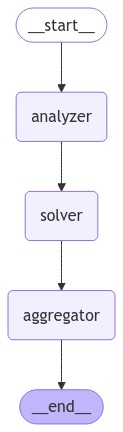

In [ ]:
# Graph structure
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from pydantic import BaseModel

# State

class State(MessagesState):
    context: list[str]
    problem: str
    sub_problems: str
    dependencies: list
    sub_problem_solutions: list
    reasoning: list
    def __init__(self, given_context):
        # super().__init__(given_context)
        self.context = given_context

class Refined(BaseModel):
    problem: str
    sub_problems: str
    dependencies: list[str]

class Solved(BaseModel):
    sub_problem_solutions: list[str]
    reasoning: list[str]

# Graph functions
def problem_analyzer(state: State):
    # Refinement prompt
    _orig_problem = state['messages'][-1].content
    _prompt = [
        SystemMessage(
            PromptTemplate.problem_analysis.format(
                Problem = _orig_problem,
                Context = state['context']
            )
        )
    ]

    # Invoke the LLM
    structured_llm = llm.with_structured_output(Refined)
    _response = structured_llm.invoke(_prompt)

    return {
        'problem': _response.problem, 
        'sub_problems': _response.sub_problems,
        'dependencies': _response.dependencies
    }

def subproblem_solver(state: State):
    # sub-problem solver
    _prompt = [
        SystemMessage(
            PromptTemplate.subproblem_solution.format(
                SubProblem = state['sub_problems'],
                Dependencies = state['dependencies'],
                Context = state['context']
            )
        )
    ]

    # Invoke the LLM
    structured_llm = llm.with_structured_output(Solved)
    _response = structured_llm.invoke(_prompt)
    
    return {
        'sub_problem_solutions': _response.sub_problem_solutions,
        'reasoning': _response.reasoning
    }

def solution_aggregator(state: State):
    # solution aggregator
    _prompt = [
        SystemMessage(
            PromptTemplate.solution_aggregation.format(
                RefinedProblem = state['problem'],  
                SubProblemSolutions = state['sub_problem_solutions'],
                Context = state['context']
            )
        )
    ]

    # Invoke the LLM
    _response = llm.invoke(_prompt)
    
    return {'messages': _response}

# Graph
graph = StateGraph(State)

# Add nodes
graph.add_node("analyzer", problem_analyzer)
graph.add_node("solver", subproblem_solver)
graph.add_node("aggregator", solution_aggregator)

# Add edges
graph.add_edge(START, "analyzer")
graph.add_edge("analyzer", "solver")
graph.add_edge("solver", "aggregator")
graph.add_edge("aggregator", END)

# Compile the graph
graph = graph.compile(checkpointer = memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
data = train_set[0]

# Extract values
id = data['id']
question = data['question']
answer = data['answer']
context = ["{}: {}".format(title, " ".join(sentences)) for title, sentences in zip(data['context']['title'], data['context']['sentences'])]

In [39]:
# Invoke the graphs
thread = {"configurable": {"thread_id": id}}
prompt = {
    'messages': question,
    'context': context
}
response = graph.invoke(prompt, thread)

In [ ]:
for m in response['messages']:
    m.pretty_print()